In [23]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np
import matplotlib.pyplot as plt
from cv_ops import MomentumOp, PositionOp

In [32]:
def hea_layer(qubits, parameters):
    circuit = cirq.Circuit()
    for i in range(len(qubits)):
        circuit += cirq.ry(parameters[3 * i]).on(qubits[i])
        circuit += cirq.rz(parameters[3 * i + 1]).on(qubits[i])
        circuit += cirq.ry(parameters[3 * i + 2]).on(qubits[i])
    for i in range(len(qubits)-1):
        circuit += cirq.CNOT(qubits[i], qubits[i + 1])
    circuit += cirq.CNOT(qubits[-1], qubits[0])
    return circuit

def cv_qaoa_layer(qubits, parameters, hamiltonian):
    return tfq.util.exponential([hamiltonian], [parameters[0]])# + tfq.util.exponential([1/2 * PositionOp(qubits).op * PositionOp(qubits).op], [parameters[1]])

def ansatz(qubits, layers, parameters, hamiltonian):
    circuit = cirq.Circuit()
    counter = 0
    for i in range(layers):
        params = parameters[counter:counter+2]
        counter += 2
        circuit += cv_qaoa_layer(qubits, params, hamiltonian)
        params = parameters[counter:counter + 3 * len(qubits)]
        counter += 3 * len(qubits)
        circuit += hea_layer(qubits, params)
    return circuit

In [33]:
def make_vqe(qubits, layers, hamiltonian):
    num_params = layers * (3 * len(qubits) + 2)
    params = sympy.symbols('vqe0:%d'%num_params)
    c = ansatz(qubits, layers, params, hamiltonian)
    ins = tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string)
    pqc = tfq.layers.PQC(c, hamiltonian, differentiator=tfq.differentiators.Adjoint())(ins)
    vqe = tf.keras.models.Model(inputs=ins, outputs=pqc)
    return vqe, c

def optimize_vqe_gradient(vqe):
    old = np.inf
    inputs = tfq.convert_to_tensor([cirq.Circuit()])
    opt = tf.keras.optimizers.Adam(learning_rate=0.01) 
    counter = 0
    energys = []
    while True:
        if (counter + 1) % 50 == 0:
            print(counter, energys[-1])
        with tf.GradientTape() as tape:
            energy = vqe(inputs)
        grads = tape.gradient(energy, vqe.trainable_variables)
        opt.apply_gradients(zip(grads, vqe.trainable_variables))
        energy = energy.numpy()[0][0]
        energys.append(energy)
        if abs(energy - old) < 1e-5:
            break
        old = energy
        counter += 1

    return energys

49 0.6916018
99 0.4650361
149 0.3414838
199 0.30067202
249 0.29001087
299 0.28354338
349 0.27947482
399 0.27301946
449 0.26172933
499 0.24449752
549 0.23642087
599 0.23340647
649 0.23181902
699 0.23076577
749 0.22959538
799 0.2279482
849 0.22561365
899 0.22233519
949 0.21820128
999 0.21396697
1049 0.20761931
1099 0.20304164
1149 0.19986156


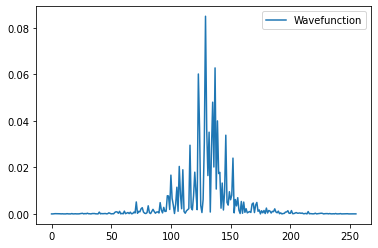

In [34]:
N = 8
layers = 8

qs = [cirq.GridQubit(0, i) for i in range(N)]
problem = (PositionOp(qs).op**2 + MomentumOp(qs).op**2)/2**(N-1)

#print(problem)

vqe, circuit = make_vqe(qs, layers, problem)
results = optimize_vqe_gradient(vqe)

params_str = list(sorted(tfq.util.get_circuit_symbols(circuit))) 
params = [sympy.symbols(i) for i in params_str] 

final_state = tfq.layers.State()(circuit, symbol_names=params, symbol_values=vqe.trainable_variables).to_tensor()
wave_fn = tf.math.real(tf.math.conj(final_state) * final_state)

plt.plot(wave_fn[0], label="Wavefunction")
plt.legend()
plt.show()

#print(results[-10:])
#plt.plot(results)
#plt.show()